<a href="https://colab.research.google.com/github/cxbxmxcx/GenReality/blob/master/GEN_6_ResNet_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title INSTALLS
!pip install livelossplot --quiet

In [2]:
#@title IMPORTS
import numpy as np
import math
import time
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.nn import functional
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
from torch.autograd import Variable
from torchvision import datasets, transforms
from IPython.display import clear_output
from livelossplot import PlotLosses

In [3]:
#@title INSPECTING DEVICE
cuda = True if torch.cuda.is_available() else False
print("Using CUDA" if cuda else "Not using CUDA")

Using CUDA


In [4]:
#@title HYPERPARAMETERS AND DATALOADERS
batch_size = 64
epochs = 5
learning_rate = 1e-4
sample_interval = 100

In [5]:
#@title DOWNLOAD DATA
import os
os.makedirs("../../data/mnist", exist_ok=True)
dataloader = torch.utils.data.DataLoader(
  datasets.FashionMNIST(
    "../../data/mnist",
    train=True,
    download=True,
    transform=transforms.Compose(
        [transforms.ToTensor(), transforms.Normalize([0.5], [0.5])]
    ),
  ),
  batch_size=batch_size,
  shuffle=True,
)

testloader = torch.utils.data.DataLoader(
  datasets.FashionMNIST(
    "../../data/mnist",
    train=False,
    download=True,
    transform=transforms.Compose(
        [transforms.ToTensor(), transforms.Normalize([0.5], [0.5])]
    ),
  ),
  batch_size=batch_size,
  shuffle=True,
)

Extracting ../../data/mnist/FashionMNIST/raw/train-images-idx3-ubyte.gz to ../../data/mnist/FashionMNIST/raw


Extracting ../../data/mnist/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ../../data/mnist/FashionMNIST/raw


Extracting ../../data/mnist/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ../../data/mnist/FashionMNIST/raw




Extracting ../../data/mnist/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ../../data/mnist/FashionMNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


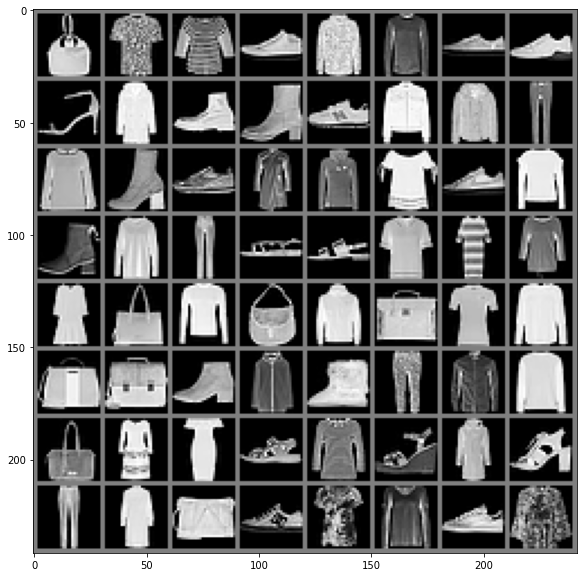

In [6]:
#@title PREVIEW THE IMAGES
def imshow(img,size=10):
  img = img / 2 + 0.5     
  npimg = img.numpy()
  plt.figure(figsize=(size, size))
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.show()

def to_img(x):    
    x = x.view(x.size(0), 1, 224, 224)
    return x

 # obtain one batch of training images
dataiter = iter(dataloader)
images, labels = dataiter.next()

imshow(make_grid(images, nrow=8))

In [7]:
#@title RESNET MODEL
def preprocess(x):
    return x.view(-1, 1, 28, 28)

def conv(in_size, out_size, pad=1): 
    return nn.Conv2d(in_size, out_size, kernel_size=3, stride=2, padding=pad)

class ResBlock(nn.Module):    
    def __init__(self, in_size:int, hidden_size:int, out_size:int, pad:int):
        super().__init__()
        self.conv1 = conv(in_size, hidden_size, pad)
        self.conv2 = conv(hidden_size, out_size, pad)
        self.batchnorm1 = nn.BatchNorm2d(hidden_size)
        self.batchnorm2 = nn.BatchNorm2d(out_size)
    
    def convblock(self, x):
        x = nn.functional.relu(self.batchnorm1(self.conv1(x)))
        x = nn.functional.relu(self.batchnorm2(self.conv2(x)))        
        return x
    
    def forward(self, x): return x + self.convblock(x) # skip connection

class ResNet(nn.Module):    
    def __init__(self, n_classes=10):
        super().__init__()
        self.res1 = ResBlock(1, 8, 16, 15)
        self.res2 = ResBlock(16, 32, 16, 15)
        self.conv = conv(16, n_classes)
        self.batchnorm = nn.BatchNorm2d(n_classes)
        self.maxpool = nn.AdaptiveMaxPool2d(1)
        
    def forward(self, x):
        x = preprocess(x)
        x = self.res1(x)
        x = self.res2(x) 
        x = self.maxpool(self.batchnorm(self.conv(x)))
        return x.view(x.size(0), -1)

In [8]:
#@title MODEL CREATION AND SUMMARIZATION
from torchsummary import summary

model = ResNet()
summary(model.cuda(), (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 28, 28]              80
       BatchNorm2d-2            [-1, 8, 28, 28]              16
            Conv2d-3           [-1, 16, 28, 28]           1,168
       BatchNorm2d-4           [-1, 16, 28, 28]              32
          ResBlock-5           [-1, 16, 28, 28]               0
            Conv2d-6           [-1, 32, 28, 28]           4,640
       BatchNorm2d-7           [-1, 32, 28, 28]              64
            Conv2d-8           [-1, 16, 28, 28]           4,624
       BatchNorm2d-9           [-1, 16, 28, 28]              32
         ResBlock-10           [-1, 16, 28, 28]               0
           Conv2d-11           [-1, 10, 14, 14]           1,450
      BatchNorm2d-12           [-1, 10, 14, 14]              20
AdaptiveMaxPool2d-13             [-1, 10, 1, 1]               0
Total params: 12,126
Trainable params: 

In [9]:
#@title LOSS AND OPTIMIZER    
loss_fn = nn.CrossEntropyLoss()

if cuda:
  model.cuda()
  loss_fn.cuda()

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

FloatTensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if cuda else torch.LongTensor

In [10]:
#@title ACCURACY FUNCTION
def accuracy(pred, labels):    
    preds = torch.argmax(pred, dim=1)
    return (preds == labels).float().mean()

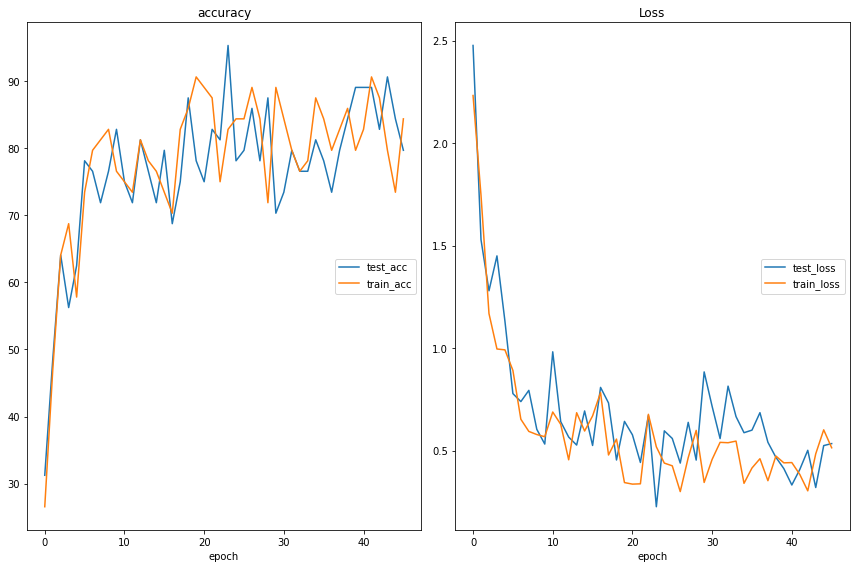

accuracy
	test_acc         	 (min:   31.250, max:   95.312, cur:   79.688)
	train_acc        	 (min:   26.562, max:   90.625, cur:   84.375)
Loss
	test_loss        	 (min:    0.227, max:    2.476, cur:    0.535)
	train_loss       	 (min:    0.300, max:    2.232, cur:    0.514)


In [11]:
#@title TRAINING
groups = {'loss': ['test_loss', 'train_loss'], 'accuracy': ['test_acc', 'train_acc']}
liveloss = PlotLosses(groups=groups)
history = {}
batches = 0
for epoch in range(epochs):    
  train_loss = 0.0 
  for images, labels in dataloader:       
        
    # Configure input        
    #labels = functional.one_hot(labels, num_classes=10)
    labels = Variable(labels.type(LongTensor))
    optimizer.zero_grad()        
    predicted = model(images.cuda())  
    #print(generated, labels)           
    loss = loss_fn(predicted, labels)
    acc = accuracy(predicted, labels)
    loss.backward()
    optimizer.step()
    batches += 1
    history["train_loss"] = loss.item()
    history["train_acc"] = acc * 100
    if batches % sample_interval == 0:
      dataiter = iter(testloader)
      images, labels = dataiter.next()
      preds = model(images.cuda())
      labels = Variable(labels.type(LongTensor))
      tloss = loss_fn(preds, labels)
      history["test_loss"] = tloss.item()
      history["test_acc"] = accuracy(preds, labels) * 100
      liveloss.update(history)
      liveloss.send()
           
    

In [12]:
#@title MORE IMAGE HELPERS
def im_show(img):   
    img = np.transpose(img, (1, 2, 0)) # convert from Tensor image
    img = np.squeeze(img)    
    plt.imshow(img)  
    
# specify the image classes
classes = ('T-Shirt','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle Boot')

def plot_images(images, labels, no):  
  rows = int(math.sqrt(no))
  plt.ion()
  fig = plt.figure(figsize=(rows*2, rows*2))      
  for idx in np.arange(no):
      ax = fig.add_subplot(rows, no/rows, idx+1, xticks=[], yticks=[])
      im_show(images[idx])
      ax.set_title(classes[labels[idx]]) 
  time.sleep(0.1)
  plt.pause(0.0001)  

accuracy 92.1875%


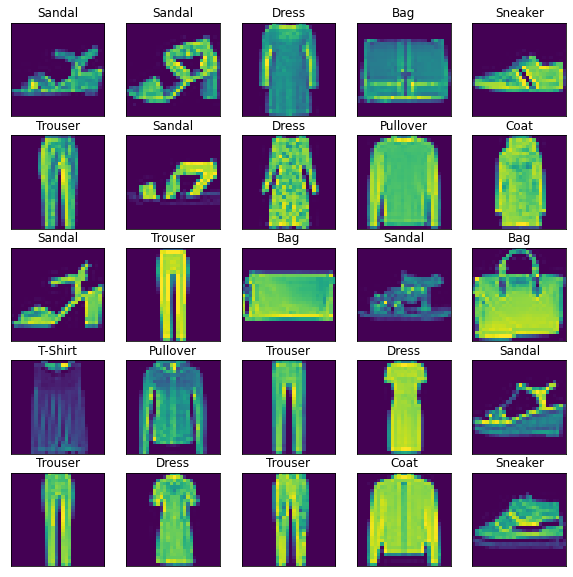

In [13]:
#@title VISUAL VALIDATION
dataiter = iter(testloader)
images, labels = dataiter.next()

preds = model(images.cuda())
values, indices = torch.max(preds, 1)
print(f"accuracy {accuracy(preds, labels.cuda()).item()*100}%")
plot_images(images.cpu().numpy(), indices.cpu().numpy(), 25)